In [21]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/pacpy')
#sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/ecogtools')
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/')


In [24]:
from __future__ import division
import pandas as pd
import os
from scipy import stats
from utils import loadmat
import scipy.io as spio
import matplotlib.gridspec as gridspec
from utils.sci_notation import sci_notation

In [25]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
savedir = os.path.join(SJdir, 'PCA', 'Figures')
savedir
base ='/home/knight/matar/MATLAB/DATA/Avgusta/'


In [26]:
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
#df[(df.subj == 'GP15') & (df.task == 'EmoGen')].elec.values

In [109]:
#eidx = np.in1d(active_elecs, s_t[1].elec.values)
#lats = dict(zip(s_t[1].elec.values, data_all[eidx, :, start_idx:end_idx].argmax(axis = -1)))


/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


## calculate peak latencies for all electrodes (ignoring type)

In [111]:
""" 
adapted from: shadeplots_elecs_stats
calculates peak latency for all electrodes in an active cluster 
goes from stim onset to max rt + 500
"""
df_lats = pd.DataFrame(columns = ['elec','lat', 'ROI'], index = [np.empty(0), np.empty(0)])
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

for s_t in df.groupby(['subj','task']): #per dataset

    subj, task = s_t[0]

    #load data
    filename = os.path.join(SJdir, 'Subjs',subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat.loadmat(filename)
    active_elecs, Params, srate, RT, data_all = [data_dict.get(k) for k in ['active_elecs','Params','srate','RTs','data_zscore']]
    
    #set up baseline (hardocded to 500 ms because my data already includes the cue in it, but the bl_st from HGmtx includes it too)
    bl_st = 500
    bl_st = bl_st/1000*srate
        
    start_idx = abs(bl_st) #start looking for peak from stimulus onset
    if task == 'DecisionAud':
        start_idx += 600/1000*srate
    elif task == 'DecisionVis':
        start_idx += 500/1000*srate
    
    end_idx = max(RT)+abs(bl_st)+(500/1000*srate)   
    RT = RT + abs(bl_st) #RTs are calculated from stim/cue onset, need to account for bl in HG_elecMTX_percent (for 500, not 1000 baseline 12/25)
    end_idx = max(RT)+(500/1000*srate)
    
    #calculate peak per electrode (on mean trace) and put in dataframe
    #arrays = [np.tile(subj, len(active_elecs)), np.tile(task, len(active_elecs))]
    tmp = pd.DataFrame(zip(active_elecs, data_all[:,:,start_idx:end_idx].mean(axis = 1).argmax(axis = 1), np.tile(np.median(RT), len(active_elecs))))
    tmp.columns = ['elec','lat','RT_median']
    tmp = tmp.merge(s_t[1][['ROI','elec', 'subj','task', 'start_idx']])
    df_lats = df_lats.append(tmp)

#adjust start idx for cue in my tasks 
df_lats.loc[(df_lats.task == 'DecisionAud'),'start_idx'] -= 600/1000*srate
df_lats.loc[(df_lats.task == 'DecisionVis'),'start_idx'] -= 500/1000*srate

#save stats
filename = os.path.join(SJdir, 'PCA', 'ShadePlots_hclust', 'elecs', 'significance_windows', 'zscore', 'by_ROI', 'all_subj_latencies.csv')
pd.DataFrame(df_lats).to_csv(filename, index = False)
filename

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/ShadePlots_hclust/elecs/significance_windows/zscore/by_ROI/all_subj_latencies.csv'

## split by ROI

In [27]:
filename = os.path.join(SJdir, 'PCA', 'ShadePlots_hclust', 'elecs', 'significance_windows', 'zscore', 'by_ROI', 'all_subj_latencies.csv')
df_lats = pd.read_csv(filename)

In [28]:
df_lats.ROI.unique()

array(['R_Temporal', 'R_Motor', 'R_PFC', 'R_Occip', 'R_Parietal', 'MFG',
       'MFG_premot', 'Broca', 'Pre_centrl', 'Post_centrl', 'ATL', 'STG',
       'Area_37', 'IPL', 'R_MFG', 'R_IFG', 'R_Pre_centrl', 'R_Post_centrl',
       'R_ATL', 'R_STG', 'R_IPL', 'MTG', 'InfTemp', 'R_MedParietal',
       'R_dACC', 'R_SMA', 'dACC', 'MedParietal', 'SMA', 'R_SPL', 'R_MTG',
       'R_InfTemp', 'OFC', 'Occip', 'IFG', 'ITG', 'R_MFG_premot', 'PreSMA',
       'SFG', 'Occip_par', 'SPL', 'PCC', 'FrPole', 'preSMA', 'R_PreSMA',
       'MedOccip'], dtype=object)

In [29]:
# frontal = ['Broca','FrPole','IFG','MFG','MFG_premot','OFC','PreSMA','Pre_centrl','SFG','SMA','dACC','preSMA', 'R_IFG','R_MFG','R_MFG_premot', 'R_PreSMA','R_Pre_centrl','R_SMA','R_dACC']
# leftfrontal = ['Broca','FrPole','IFG','MFG','MFG_premot','OFC','PreSMA','Pre_centrl','SFG','SMA','dACC','preSMA']
# PFC = ['Broca','FrPole','IFG','MFG','MFG_premot','OFC','PreSMA','SFG','SMA','dACC','preSMA', 'R_IFG','R_MFG','R_MFG_premot', 'R_PreSMA','R_SMA','R_dACC']

In [30]:
#define regions 

PFC = ['MFG_premot','R_MFG_premot', 'Broca', 'FrPole', 'IFG', 'MFG', 'OFC', 'SFG', 'dACC', 'preSMA', 'PreSMA', 'R_IFG', 'R_MFG', 'R_dACC', 'R_PreSMA', 'R_PFC']

motor = ['R_SMA', 'Pre_centrl', 'Post_centrl', 'R_Post_centrl', 'R_Pre_centrl',  'SMA', 'R_Motor']

auditory = ['ITG', 'MTG','R_MTG', 'R_STG', 'STG', 'R_Temporal']

visual = ['Occip', 'Occip_par', 'MedOccip', 'R_Occip']

In [31]:
# assign regions
df_lats['region'] = np.nan
regions = dict(zip(['PFC','motor','auditory','visual'], [PFC,motor,auditory, visual]))
for r in regions.keys():
    cond = df_lats.ROI.isin(regions[r])
    #df_lats['region'].loc[cond] = r
    df_lats.loc[cond, 'region'] = r
#drop elecs that don't belong to one of predefined regions
df_lats = df_lats.loc[pd.notnull(df_lats['region'])]
df_lats = df_lats.reset_index() #important so that remove the correct rows!!

In [32]:
df_lats[df_lats.subj == 'ST27'].groupby('region').count()

,index,ROI,RT_median,elec,lat,start_idx,subj,task
region,,,,,,,,
PFC,12,12,12,12,12,12,12,12
motor,3,3,3,3,3,3,3,3
visual,9,9,9,9,9,9,9,9


In [33]:
#drop the sensory elecs that are the wrong coverage for the task (ie temporal in visual task)
auditory_tasks = ['EmoGen', 'EmoRep', 'SelfAud', 'DecisionAud']
visual_tasks = ['FaceEmo', 'FaceGen', 'SelfVis', 'DecisionVis']
df_lats = df_lats.drop(df_lats[(df_lats.region == 'visual') & (df_lats.task.isin(auditory_tasks))].index)
df_lats = df_lats.drop(df_lats[(df_lats.region == 'auditory') & (df_lats.task.isin(visual_tasks))].index)

#rename auditory/visual to just sensory
df_lats.region = df_lats.region.apply(lambda x: 'sensory' if x in(['auditory','visual']) else x)

In [34]:
df_lats[df_lats.subj == 'ST27'].groupby('region').count()

,index,ROI,RT_median,elec,lat,start_idx,subj,task
region,,,,,,,,
PFC,12,12,12,12,12,12,12,12
motor,3,3,3,3,3,3,3,3
sensory,9,9,9,9,9,9,9,9


In [35]:
## drop ST6 Self Vis sensory elecs
df_lats.loc[df_lats[(df_lats.task == 'SelfVis') & (df_lats.region == 'sensory') & (df_lats.subj == 'ST6')].index]
df_lats = df_lats.drop(df_lats[(df_lats.task == 'SelfVis') & (df_lats.region == 'sensory') & (df_lats.subj == 'ST6')].index)

#after dropping, don't use iloc, use just loc

In [36]:
f = {'elec':['count'], 'lat':['mean'], 'RT_median':['mean'], 'start_idx':['mean']} #use means because few elecs
df_lats = df_lats.groupby(['subj','task', 'region']).agg(f)

In [37]:
filename = os.path.join(SJdir, 'PCA', 'ShadePlots_hclust', 'elecs', 'significance_windows', 'zscore', 'by_ROI', 'all_subj_latencies_meanbyregion.csv')
df_lats.to_csv(filename, index = True)

print filename
df_lats.loc['ST27','DecisionVis']

/home/knight/matar/MATLAB/DATA/Avgusta/PCA/ShadePlots_hclust/elecs/significance_windows/zscore/by_ROI/all_subj_latencies_meanbyregion.csv


,lat,RT_median,elec,start_idx
,mean,mean,count,mean
region,,,,
PFC,573.666667,1865.0,12,99.416667
motor,692.666667,1865.0,3,24.666667
sensory,168.555556,1865.0,9,36.444444


### plot ROI

In [38]:
[1,2,3,4,5][1::2]

[2, 4]

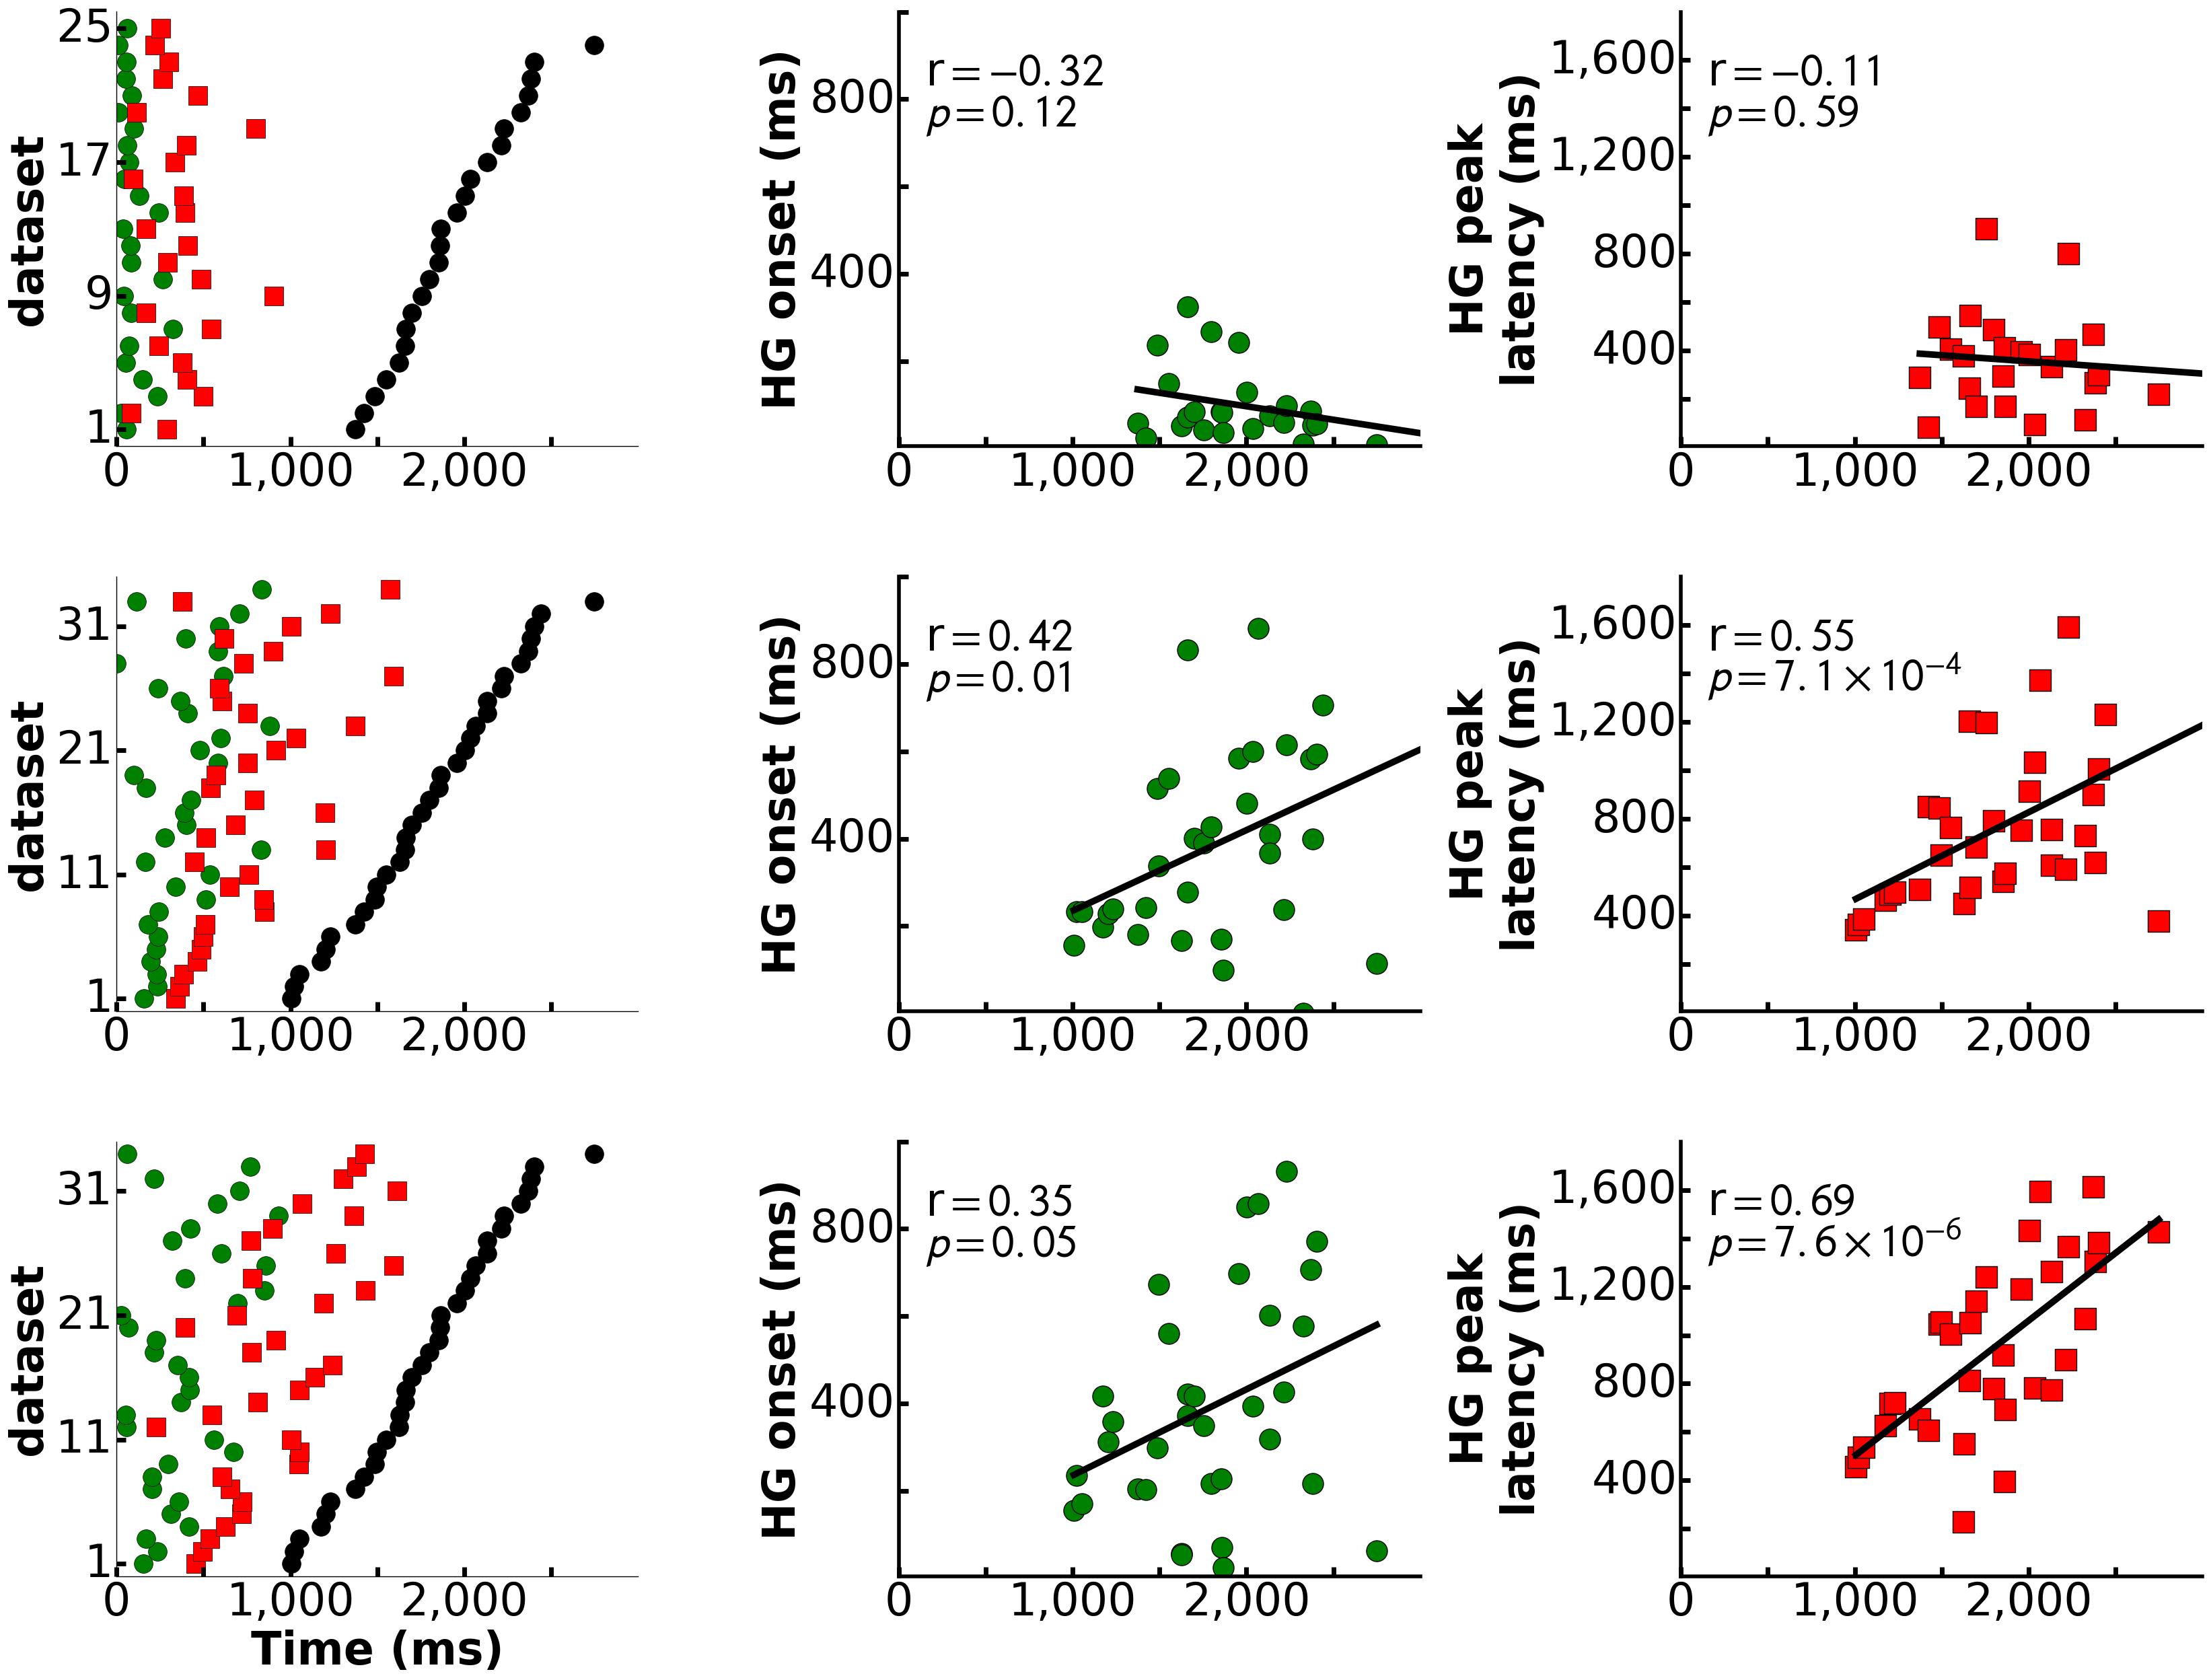

In [47]:
#'single trial' plot for all datasets for

f, ax = plt.subplots(3,3, figsize = (40,30))


for i, r in enumerate(['sensory', 'PFC', 'motor']):
    
    df_sorted = df_lats.iloc[df_lats.index.get_level_values('region') == r].sort_values(by = [('RT_median','mean')])
    num_datasets = df_sorted.shape[0]
    
    onsets = df_sorted['start_idx']['mean'].values.squeeze()
    rts = df_sorted.RT_median.values.squeeze()
    lats = df_sorted.lat['mean'].values.squeeze()    
    
    #single trials
    ax[i,0].plot(rts, np.arange(num_datasets), marker = 'o', color = 'k', lw = 0, markersize = 20, label = 'RT')
    ax[i,0].plot(onsets, np.arange(num_datasets), marker = 'o',color = 'g', lw = 0, markersize = 20, label = 'HG onset')
    ax[i,0].plot(lats, np.arange(num_datasets), marker = 's',color = 'r', lw = 0, markersize = 20)# label = 'semi-static latency\n(HGonset : max(RT) + 500')
    ax[i,0].set_ylabel('dataset', weight = 'bold', fontsize = 48)
    ax[i,0].set_xlim([0,3000])
    ax[i,0].xaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
    ax[i,0].yaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
    ax[i,0].tick_params(axis='both', which = 'both', top = 'off', bottom = 'on', right = 'off', left = 'on')
    ax[i,0].spines['top'].set_visible(False)
    ax[i,0].spines['right'].set_visible(False)
    ax[i,0].spines['left'].set_bounds(-1, num_datasets)
    ax[i,0].spines['bottom'].set_bounds(0, 3000)
    ax[i,0].set_xticks(np.arange(0, 3000, 500))    
    ax[i,0].yaxis.set_major_locator(MaxNLocator(nbins=5)) # with 3 bins you will have 4 ticks)
    ax[i,0].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(ax[i,0].get_xticklabels()[1::2], visible=False)
    ax[i,0].set_ylim([-1, num_datasets]) #change yaxis indexing
    ylab = ax[i,0].get_yticks()
    ax[i,0].set_yticklabels((ylab+1).astype(int))
    ax[-1,0].set_xlabel('Time (ms)', weight = 'bold', fontsize = 48)
    
    #scatterplots - HGonsets
    ax[i,1].scatter(rts, onsets, marker = 'o', s = 500, facecolor = 'g')
    R, p = stats.pearsonr(onsets, rts)
    ax[i,1].set_ylabel('HG onset (ms)', weight = 'bold', fontsize = 48)
    ax[i,2].set_ylim([0,1000])
    
    A = np.vstack([rts,np.ones(len(rts))]).T
    m,c = np.linalg.lstsq(A,np.array(onsets))[0]
    ax[i,1].plot(rts,rts*m+c, color = 'k', linewidth = 7) 

    if p > 0.001:
        ax[i,1].text(0.05, 0.81, r"r$ = {%.2f}$" %(R), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,1].text(0.05, 0.71, r"$p = {%.2f}$" %(p), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)        
    else:
        ax[i,1].text(0.05, 0.81, r"r$ = {%.2f}$" %(R), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,1].text(0.05, 0.71, r"$p = $%s" %(sci_notation(p)), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
    
    ax[i,1].set_ylim(ymax = 1000)
    ax[i,1].set_yticks(np.arange(0, 1100, 200))

    #scatterplots - latencies
    ax[i,2].scatter(rts, lats, marker = 's', s = 500, facecolor = 'r')
    R, p = stats.pearsonr(lats, rts)
    ax[i,2].set_ylabel('HG peak\nlatency (ms)',weight = 'bold', fontsize = 48)
    ax[i,2].set_ylim([0, 1700])
    
    A = np.vstack([rts,np.ones(len(rts))]).T
    m,c = np.linalg.lstsq(A,np.array(lats))[0]
    ax[i,2].plot(rts,rts*m+c, color = 'k', linewidth = 7, label = 'r = %.2f\np = %.3f' %(R, p)) 
    
    if p > 0.001:
        ax[i,2].text(0.05, 0.81, r"r$ = {%.2f}$" %(R), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,2].text(0.05, 0.71, r"$p = {%.2f}$" %(p), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)        
    else:
        ax[i,2].text(0.05, 0.81, r"r$ = {%.2f}$" %(R), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,2].text(0.05, 0.71, r"$p = $%s" %(sci_notation(p)), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)

    ax[i,2].set_ylim(ymax = 1800)
    ax[i,2].set_yticks(np.arange(0, 1800, 200))

    for a in range(1,3):
        ax[i,a].patch.set_facecolor('white')
        #ax[i,a].autoscale(tight=True)
        ax[i,a].spines['top'].set_visible(False)
        ax[i,a].spines['right'].set_visible(False)
        ax[i,a].spines['bottom'].set_linewidth(4)
        ax[i,a].spines['left'].set_linewidth(4)
        ax[i,a].get_xaxis().tick_bottom()
        ax[i,a].get_yaxis().tick_left()
        ax[i,a].xaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
        ax[i,a].yaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
        ax[i,a].set_xlim([0, 3000])
        ax[i,a].tick_params( axis='both', which = 'both', top = 'off', bottom = 'on', right = 'off', left = 'on')
        ax[i,a].spines['bottom'].set_bounds(0, 3000)
        ax[i,a].set_xticks(np.arange(0, 3000, 500))
        #ax[i,a].yaxis.set_major_locator(MaxNLocator(nbins=5)) # with 3 bins you will have 4 ticks
        #ax[-1,a].set_xlabel('RT (ms)',weight = 'bold', fontsize = 48)
        plt.setp(ax[i,a].get_xticklabels()[1::2], visible=False)
        plt.setp(ax[i,a].get_yticklabels()[1::2], visible=False)
        ax[i,a].set_ylim(bottom=5)
        ax[i,a].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax[i,a].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
f.subplots_adjust(wspace = 0.5)
f.subplots_adjust(hspace = 0.3)

filename = os.path.join(savedir, 'singletrials_and_correlations_onsets_and_latencies_byROIs_noST6SelfVisSensory.png')
f.savefig(filename, bbox_inches='tight', dpi = 150)


In [59]:
filename

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures/singletrials_and_correlations_onsets_and_latencies_byROIs_noST6SelfVisSensory.png'

## by pattern 

In [7]:
#### calculate all latencies for all electrodes (keep track of pattern)
""" 
adapted from: shadeplots_elecs_stats
calculates peak latency for all electrodes in an active cluster 
goes from stim onset to max rt + 500
"""
df_lats = pd.DataFrame(columns = ['elec','lat', 'pattern'], index = [np.empty(0), np.empty(0)])
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

for s_t in df.groupby(['subj','task']): #per dataset

    subj, task = s_t[0]

    #load data
    filename = os.path.join(SJdir, 'Subjs',subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat.loadmat(filename)
    active_elecs, Params, srate, RT, data_all = [data_dict.get(k) for k in ['active_elecs','Params','srate','RTs','data_zscore']]
    
    idx = np.in1d(active_elecs, s_t[1].elec)
    
    #set up baseline (hardocded to 500 ms because my data already includes the cue in it, but the bl_st from HGmtx includes it too)
    bl_st = 500
    bl_st = bl_st/1000*srate
        
    start_idx = abs(bl_st) #start from stimulus onset
    if task == 'DecisionAud':
        start_idx += 600/1000*srate
    elif task == 'DecisionVis':
        start_idx += 500/1000*srate
    
    end_idx = max(RT)+abs(bl_st)+(500/1000*srate)
        
    print (subj, task, bl_st, mean(RT), start_idx, end_idx)
    
    #calculate peak per electrode (on mean trace) and put in dataframe

    tmp = pd.DataFrame(zip(active_elecs, data_all[:,:,start_idx:end_idx].mean(axis = 1).argmax(axis = 1), np.tile(np.median(RT), len(active_elecs))))
    tmp.columns = ['elec','lat','RT_median']
    tmp = tmp.merge(s_t[1][['pattern','elec', 'subj','task', 'start_idx']])
    df_lats = df_lats.append(tmp)
    
#adjust for cue in my tasks (which were added above)
df_lats.loc[(df_lats.task == 'DecisionAud'),'start_idx'] -= 600/1000*srate
df_lats.loc[(df_lats.task == 'DecisionVis'),'start_idx'] -= 500/1000*srate

#save stats
df_lats = pd.DataFrame(df_lats)
filename = os.path.join(SJdir, 'PCA', 'ShadePlots_hclust', 'elecs', 'significance_windows', 'zscore', 'by_pattern_fixedwindows', 'all_subj_latencies.csv')
#df_lats.to_csv(filename, index = False)

('CP7', 'DecisionAud', 500.0, 2064.0967741935483, 1100.0, 4761.0)


/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('CP9', 'DecisionAud', 500.0, 2245.3576923076921, 1100.0, 3625.0)
('GP15', 'EmoGen', 500.0, 2002.8707482993198, 500.0, 4798.0)
('GP15', 'EmoRep', 500.0, 1003.2017543859649, 500.0, 2396.0)
('GP15', 'FaceEmo', 500.0, 750.92366412213744, 500.0, 2204.0)
('GP15', 'FaceGen', 500.0, 717.86259541984737, 500.0, 2144.0)
('GP15', 'SelfAud', 500.0, 1657.0365853658536, 500.0, 4137.0)
('GP15', 'SelfVis', 500.0, 1068.0649350649351, 500.0, 2892.0)
('GP28', 'SelfAud', 500.0, 1291.5135135135135, 500.0, 3602.0)
('GP28', 'SelfVis', 500.0, 1666.0595238095239, 500.0, 4323.0)
('GP35', 'EmoGen', 500.0, 1373.911111111111, 500.0, 3620.0)
('GP35', 'EmoRep', 500.0, 903.05882352941171, 500.0, 2314.0)
('GP35', 'FaceEmo', 500.0, 600.11538461538464, 500.0, 2109.0)
('GP35', 'FaceGen', 500.0, 536.03614457831327, 500.0, 1904.0)
('JH10', 'EmoRep', 500.0, 1310.5507246376812, 500.0, 2982.0)
('JH10', 'SelfAud', 500.0, 1811.8196721311476, 500.0, 3964.0)
('JH17', 'EmoRep', 500.0, 1170.04, 500.0, 2465.0)
('JH17', 'SelfAud', 50

In [8]:
#skipping cue
print df_lats[df_lats.task == 'DecisionVis'].RT_median.mean()
df_lats[(df_lats.task == 'DecisionVis') & (df_lats.pattern == 'SR')].lat.mean()

1268.88461538


303.9166666666667

## split by pattern 

In [10]:
f = {'elec':['count'], 'lat':['mean'], 'RT_median':['mean'], 'start_idx':['mean']} #use means because few elecs
df_lats = df_lats.groupby(['subj','task', 'pattern']).agg(f)

In [82]:
filename = os.path.join(SJdir, 'PCA', 'ShadePlots_hclust', 'elecs', 'significance_windows', 'zscore', 'by_pattern_fixedwindows', 'all_subj_latencies_meanbypattern.csv')
#df_lats.to_csv(filename, index = True)

print filename
df_lats.loc['GP35','EmoGen']

/home/knight/matar/MATLAB/DATA/Avgusta/PCA/ShadePlots_hclust/elecs/significance_windows/zscore/by_pattern_fixedwindows/all_subj_latencies_meanbypattern.csv


,lat,RT_median,elec,start_idx
,mean,mean,count,mean
pattern,,,,
D,654.352941,1298.0,17,242.529412
R,1050.500000,1298.0,12,595.333333
SR,248.555556,1298.0,9,28.444444


In [16]:
df_lats.loc['CP7','DecisionAud']

,lat,RT_median,elec,start_idx
,mean,mean,count,mean
pattern,,,,
D,425.000000,1827.0,2,0.000000
R,1199.142857,1827.0,7,644.857143
S,125.750000,1827.0,4,29.000000
SR,119.000000,1827.0,3,36.333333
sustained,113.000000,1827.0,1,12.000000


In [18]:
df_lats[(df_lats['lat','mean'])<(df_lats['start_idx','mean'])]

,,,lat,RT_median,elec,start_idx
,,,mean,mean,count,mean
subj,task,pattern,,,,


## plot

In [66]:
filename = os.path.join(SJdir, 'PCA', 'ShadePlots_hclust', 'elecs', 'significance_windows', 'zscore', 'by_pattern_fixedwindows', 'all_subj_latencies_meanbypattern.csv')
df_lats = pd.read_csv(filename)

# plot single trials by pattern 
## based on old code from original notebook

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures


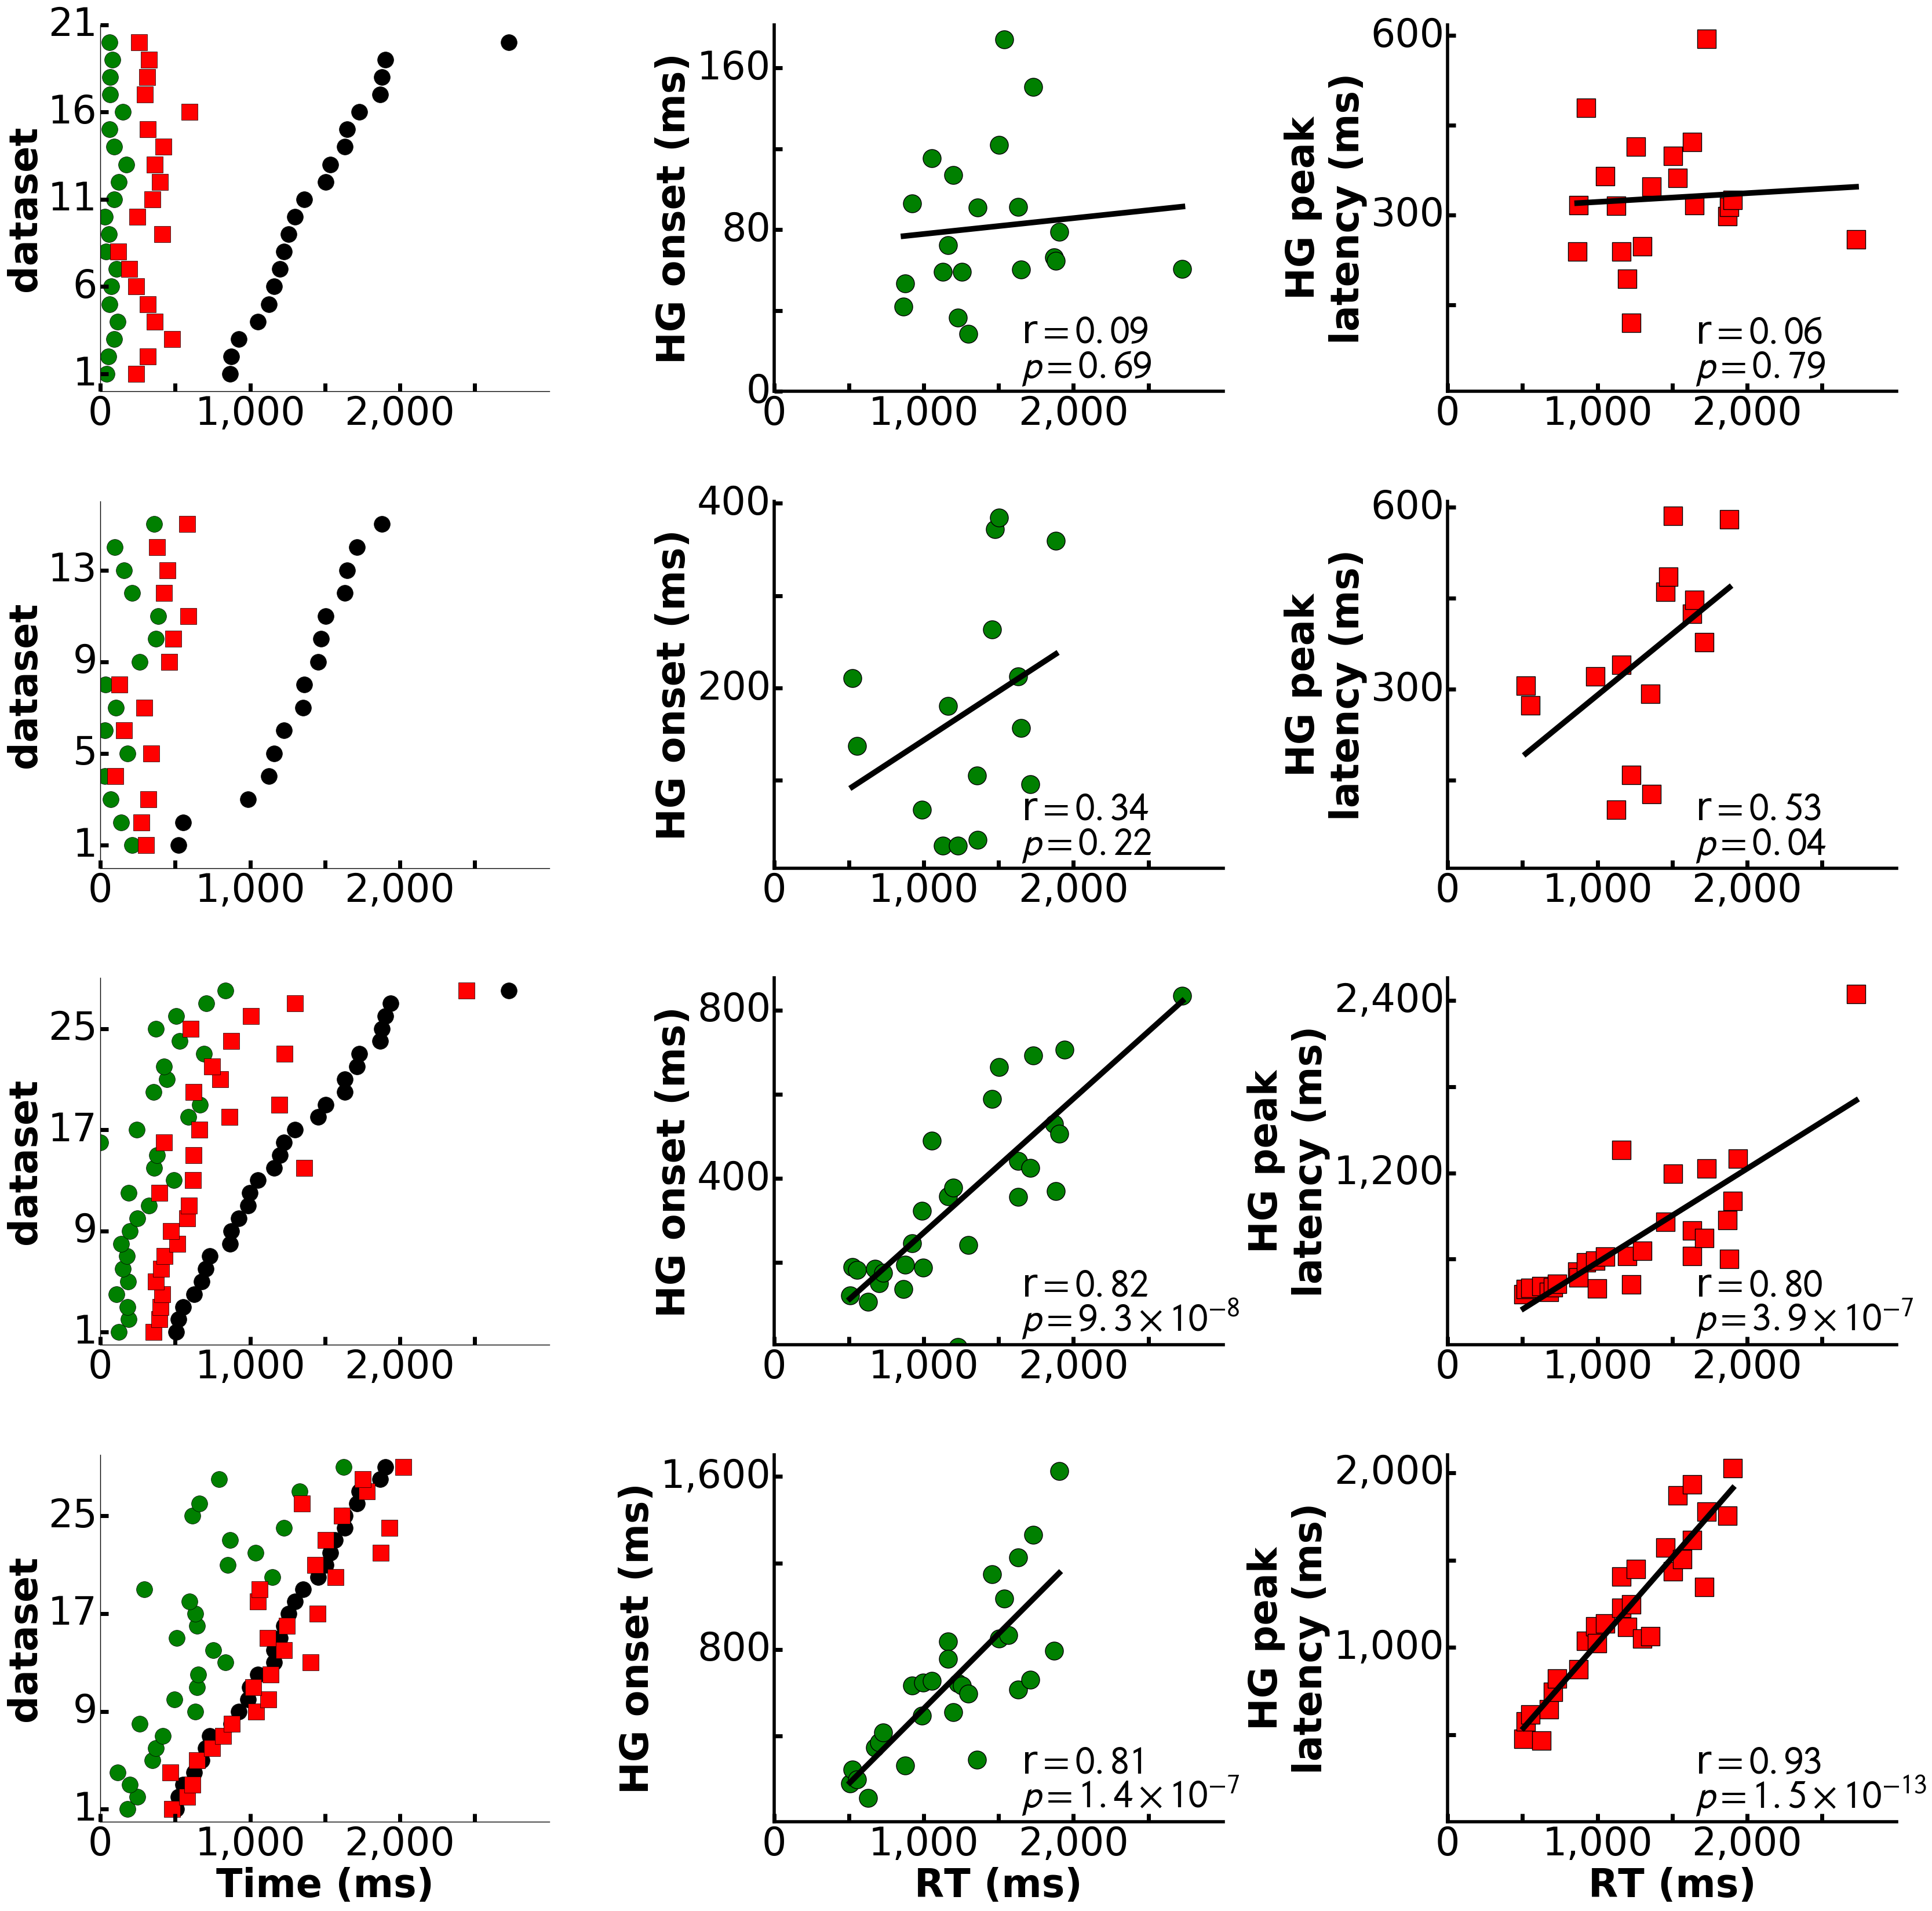

In [19]:
#'single trial' plot for all datasets for pattern - on a fixed window (stim onset to max RT + 500)

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

idx = df[(df.pattern == 'R') & (df.start_idx == 0)].index
df = df.drop(idx)

idx = df.task.isin(['DecisionAud'])
df.loc[idx,'start_idx'] = df.loc[idx].start_idx - 600
df.loc[idx,'RTs_median'] = df.loc[idx].RTs_median - 600
df.loc[idx,'lats_static'] = df.loc[idx].lats_static - 600

idx = df.task.isin(['DecisionVis'])
df.loc[idx,'start_idx'] = df.loc[idx].start_idx - 500
df.loc[idx,'RTs_median'] = df.loc[idx].RTs_median - 500
df.loc[idx,'lats_static'] = df.loc[idx].lats_static - 500
    

df['lats_semi_static_adjusted'] = df.lats_semi_static + df.start_idx #for D and R
df['lats_adjusted'] = df.lats + df.start_idx #for S and SR

elec_types = ['SR','S','D','R']

f, ax = plt.subplots(4,3, figsize = (40,40))

for i, pattern in enumerate(elec_types):
    
    df_sorted = df[df.pattern == pattern].groupby(['subj','task'])[['RTs_median','start_idx','lats_semi_static_adjusted', 'lats_adjusted']].mean().sort('RTs_median') 
    num_datasets = df_sorted.shape[0]
    
    if pattern in ['D','R']: #use different window params for D and R than S and SR
        lats = df_sorted['lats_semi_static_adjusted'] 
    else:
        lats = df_sorted['lats_adjusted']

    #single trials
    ax[i,0].plot(df_sorted.RTs_median, np.arange(num_datasets), marker = 'o', color = 'k', lw = 0, markersize = 20, label = 'RT')
    ax[i,0].plot(df_sorted.start_idx, np.arange(num_datasets), marker = 'o',color = 'g', lw = 0, markersize = 20, label = 'HG onset')
    ax[i,0].plot(lats, np.arange(num_datasets), marker = 's',color = 'r', lw = 0, markersize = 20, label = 'semi-static latency\n(HGonset : max(RT) + 500')
    ax[i,0].set_ylabel('dataset', weight = 'bold', fontsize = 48)
    ax[i,0].set_xlim([0,3000])
    ax[i,0].xaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
    ax[i,0].yaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
    ax[i,0].tick_params(axis='both', which = 'both', top = 'off', bottom = 'on', right = 'off', left = 'on')
    ax[i,0].spines['top'].set_visible(False)
    ax[i,0].spines['right'].set_visible(False)
    ax[i,0].spines['left'].set_bounds(-1, num_datasets)
    ax[i,0].spines['bottom'].set_bounds(0, 3000)
    ax[i,0].set_xticks(np.arange(0, 3000, 500))    
    ax[i,0].yaxis.set_major_locator(MaxNLocator(nbins=5)) # with 3 bins you will have 4 ticks)
    ax[i,0].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(ax[i,0].get_xticklabels()[1::2], visible=False)
    ax[i,0].set_ylim([-1, num_datasets]) #change yaxis indexing
    ylab = ax[i,0].get_yticks()
    ax[i,0].set_yticklabels((ylab+1).astype(int))

    ax[-1,0].set_xlabel('Time (ms)', weight = 'bold', fontsize = 48)

    ax[i,0].set_ylim([-1, num_datasets]) #change yaxis indexing
    ylab = ax[i,0].get_yticks()
    ax[i,0].set_yticklabels((ylab+1).astype(int))    
    
    #scatterplots - HGonsets
    onsets = df_sorted['start_idx']
    rts = df_sorted.RTs_median
    
    ax[i,1].scatter(rts, onsets, marker = 'o', s = 500, facecolor = 'g')
    R, p = stats.pearsonr(onsets, rts)
    
#     if i < 3: #pad axes so aligned
#         ax[i,1].set_ylabel('HG onset (ms)', weight = 'bold', fontsize = 48, labelpad = 50)
#     else:
    ax[i,1].set_ylabel('HG onset (ms)', weight = 'bold', fontsize = 48)

    A = np.vstack([rts,np.ones(len(rts))]).T
    m,c = np.linalg.lstsq(A,np.array(onsets))[0]
    ax[i,1].plot(rts,rts*m+c, color = 'k', linewidth = 7) 

    if p > 0.0001:
        ax[i,1].text(0.55, 0.11, r"r$ = {%.2f}$" %(R), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,1].text(0.55, 0.01, r"$p = {%.2f}$" %(p), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)        
    else:
        #ax[i,2].text(0.55, 0.01, r"r$ = {%.2f}$" '\n' r"$p = $%s" %(R, sci_notation(p)), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,1].text(0.55, 0.11, r"r$ = {%.2f}$" %(R), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,1].text(0.55, 0.01, r"$p = $%s" %(sci_notation(p)), transform = ax[i,1].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)

    ax[0,1].set_ylim(ymin = 0) #hardcoded because of zero onset
    
    #scatterplots - latencies
    ax[i,2].scatter(rts, lats, marker = 's', s = 500, facecolor = 'r')
    R, p = stats.pearsonr(lats, rts)
#     if i < 2:
#         ax[i,2].set_ylabel('HG peak\nlatency (ms)',weight = 'bold', fontsize = 48, labelpad = 50)
#     else:
    ax[i,2].set_ylabel('HG peak\nlatency (ms)',weight = 'bold', fontsize = 48)
    
    
    A = np.vstack([rts,np.ones(len(rts))]).T
    m,c = np.linalg.lstsq(A,np.array(lats))[0]
    ax[i,2].plot(rts,rts*m+c, color = 'k', linewidth = 7, label = 'r = %.2f\np = %.3f' %(R, p)) 
    
    if p > 0.0001:
        ax[i,2].text(0.55, 0.11, r"r$ = {%.2f}$" %(R), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,2].text(0.55, 0.01, r"$p = {%.2f}$" %(p), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)        
    else:
        #ax[i,2].text(0.55, 0.01, r"r$ = {%.2f}$" '\n' r"$p = $%s" %(R, sci_notation(p)), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,2].text(0.55, 0.11, r"r$ = {%.2f}$" %(R), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)
        ax[i,2].text(0.55, 0.01, r"$p = $%s" %(sci_notation(p)), transform = ax[i,2].transAxes, verticalalignment = 'bottom', horizontalalignment = 'left', fontsize = 48)

 
    for a in range(1,3):
        ax[i,a].patch.set_facecolor('white')
        ax[i,a].autoscale(tight=True)
        ax[i,a].spines['top'].set_visible(False)
        ax[i,a].spines['right'].set_visible(False)
        ax[i,a].spines['bottom'].set_linewidth(4)
        ax[i,a].spines['left'].set_linewidth(4)
        ax[i,a].get_xaxis().tick_bottom()
        ax[i,a].get_yaxis().tick_left()
        ax[i,a].xaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
        ax[i,a].yaxis.set_tick_params(labelsize = 48, length = 10, width = 5)
        ax[i,a].set_xlim([0, 3000])
        ax[i,a].tick_params( axis='both', which = 'both', top = 'off', bottom = 'on', right = 'off', left = 'on')
        ax[i,a].spines['bottom'].set_bounds(0, 3000)
        ax[i,a].set_xticks(np.arange(0, 3000, 500))
        ax[i,a].yaxis.set_major_locator(MaxNLocator(nbins=5)) # with 3 bins you will have 4 ticks
        ax[3,a].set_xlabel('RT (ms)',weight = 'bold', fontsize = 48)        
        plt.setp(ax[i,a].get_xticklabels()[1::2], visible=False)
        plt.setp(ax[i,a].get_yticklabels()[1::2], visible=False)
        ax[i,a].set_ylim(bottom=5)
        ax[i,a].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax[i,a].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
f.subplots_adjust(wspace = 0.5)
f.subplots_adjust(hspace = 0.3)

        
filename = os.path.join(savedir, 'singletrials_and_correlations_onsets_and_latencies_ALL_pvals_commas_plus1_withticks.png')
f.savefig(filename, bbox_inches='tight', dpi = 150)


print savedir


In [ ]:
df_lats